#  Deep Learning-Based Semantic Segmentation Techniques on Carla Dataset


## Loading libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [22]:
!cp -r /content/drive/MyDrive/thesis/256_np_array /content/np_files

In [3]:
#Import builtin libraries
import os


In [4]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 18.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-man

In [5]:
#Import third party libraries
import cv2
import numpy as np
import torch
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import accuracy_score

#same procedure for "froms"
from matplotlib import pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms.functional import center_crop
from torchmetrics.classification import Dice
from torchmetrics import JaccardIndex, Accuracy
from torchmetrics.segmentation import MeanIoU
from tqdm.auto import tqdm



## Set the Random State


In [6]:
torch.manual_seed(1)
# Set numpy random seed, if issues use random state
np.random.seed(1)

## Loading the Data

In [ ]:
# Base directory containing all data parts
base_dir = 'carla-capture'

#list of subdirectories
data_parts = ['dataA', 'dataB', 'dataC', 'dataD', 'dataE']

### obtaining Path

In [ ]:
#making a list to store images
image_paths = []

# Loop through each data part subdirectory
for part in data_parts:
    # Set the directory for images
    datadir_images = os.path.join(base_dir, part, 'CameraRGB/')
    # Load the image paths in a list if the directory exists
    if os.path.exists(datadir_images):
        filenames_images = [name for name in os.listdir(datadir_images) if name.endswith('.png')]
        # Combine the image path with the OS path
        image_paths.extend([os.path.join(datadir_images, filename) for filename in filenames_images])


# for path in image_paths:
#     print(path)
print(len(image_paths))

5000


In [ ]:
# same procedur for labels
label_paths = []

# Loop through each data part subdirectory
for part in data_parts:
    # Set the directory for labels
    datadir_labels = os.path.join(base_dir, part, 'CameraSeg/')
    # Load the label paths in a list if the directory exists
    if os.path.exists(datadir_labels):
        filenames_labels = [name for name in os.listdir(datadir_labels) if name.endswith('.png')]
        # Combine the label path with the OS path
        label_paths.extend([os.path.join(datadir_labels, name) for name in filenames_labels])


# for path in label_paths:
#     print(path)


print(len(label_paths))

5000


## Displaying the data

In [ ]:
# Load images and convert them from BGR to RGB
# Images = [cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB) for path in image_paths]
# labels=[cv2.imread(path) for path in label_paths]

# Convert Images to numpy array then convert them from BGR to RGB
# Images= np.array(Images)[..., ::-1]

x = [cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB) for path in image_paths]
y = [cv2.imread(path) for path in label_paths]




NameError: name 'image_paths' is not defined

In [ ]:
x = [cv2.resize(img, (256, 256), interpolation = cv2.INTER_AREA) for img in x]
y = [cv2.resize(img, (256, 256), interpolation = cv2.INTER_AREA) for img in y]

NameError: name 'x' is not defined

## saving the Data

In [ ]:
# Convert images and labels to numpy arrays
# x = np.array(Images)
# y = np.array(labels)

x = np.array(x)
y = np.array(y)


In [ ]:
# x = x.reshape( x.shape[0], x.shape[3], x.shape[1], x.shape[2])
#y = y.reshape( y.shape[0], y.shape[3], y.shape[1], y.shape[2])

x = x.transpose(0, 3, 1, 2)

In [ ]:
x.shape

(5000, 3, 256, 256)

In [ ]:
x = x.transpose(0, 2, 3, 1)

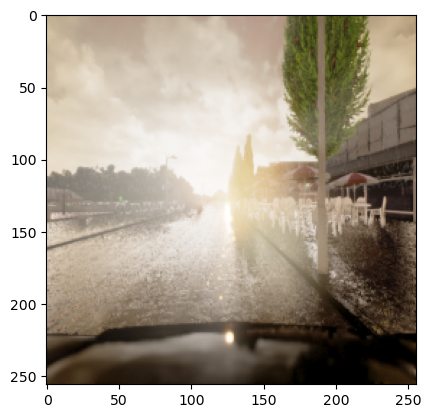

In [ ]:
plt.imshow(x[0])

In [ ]:
#split training and validation_test
x_train, x_valtest, y_train, y_valtest=train_test_split(x, y , test_size= 0.4, random_state= 1)

# Split validation-test to validation AND test
x_val, x_test, y_val, y_test= train_test_split(x_valtest, y_valtest, test_size= 0.5, random_state= 1)

In [ ]:
# saving the data
np.save( "images_train", x_train)
np.save( "labels_train", y_train)
np.save( "images_test", x_test)
np.save( "labels_test", y_test)
np.save( "images_val", x_val)
np.save( "labels_val", y_val)

## Pytroch Data Loading

In [7]:
class loadDatasets(Dataset):
    def __init__(self, image_path, label_path):

        self.image = np.load(image_path)
        self.label= np.load(label_path)

    def __getitem__(self, index):

        x = self.image[index, :, :, :]
        x = torch.tensor(x, dtype=torch.float32)


        y = self.label[index, :, :, :]
        y = np.max(y, axis=2)
        y= torch.tensor(y, dtype=torch.long)

        return x, y

    def __len__(self):
        return len(self.image)

## Defining U_Net Architecture

### DoubleConv

In [8]:
class DoubleConv(nn.Module):
    ''' two convolutions followed by a max pool operation.'''

    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3)
        self.relu = nn.ReLU()

        # If I want to use sequential
        # self.block=nn.sequential (nn.conv2d(in_channels, out_channels, kernel_size=3),
        #                          nn.Relu(),
        #                          nn.conv2d(out_channels, out_channels, kernel_size=3),
        #                          nn.Relu(),)

    def forward(self, x):
        """"""
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)

        # If I want to use sequential
        #x = self.block(x)

        return x

In [9]:
class Unet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512]):
        super(Unet, self).__init__()

        # Down double conv
        self.doubleconv_1 = DoubleConv(in_channels, features[0])
        self.doubleconv_2 = DoubleConv(features[0], features[1])
        self.doubleconv_3 = DoubleConv(features[1], features[2])
        self.doubleconv_4 = DoubleConv(features[2], features[3])

        # Middle double conv
        self.doubleconv_5 = DoubleConv(features[3], features[3] * 2)

        # Up double conv
        self.doubleconv_6 = DoubleConv(features[3] * 2 + features[3], features[3])
        self.doubleconv_7 = DoubleConv(features[3] + features[2], features[2])
        self.doubleconv_8 = DoubleConv(features[2] + features[1], features[1])
        self.doubleconv_9 = DoubleConv(features[1] + features[0], features[0])

        # Final conv
        self.final = nn.Conv2d(features[0], out_channels, kernel_size=1)

        # Down and up sampling
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.upsample = nn.Upsample(scale_factor=3, mode='bilinear', align_corners=True)



    #adding skip connections
    def forward(self, x):
        skip_connections = []

        # Downward part
        x = self.doubleconv_1(x)
        skip_connections.append(x)
        x = self.pool(x)

        x = self.doubleconv_2(x)
        skip_connections.append(x)
        x = self.pool(x)

        x = self.doubleconv_3(x)
        skip_connections.append(x)
        x = self.pool(x)

        x = self.doubleconv_4(x)
        skip_connections.append(x)
        x = self.pool(x)

        # Middle part
        x = self.doubleconv_5(x)

        # Reversing the skip connections for up part
        skip_connections = skip_connections[::-1]

        # Upward part with skip connections
        x = self.upsample(x)
        skip_connection = center_crop(skip_connections[0], (x.shape[2], x.shape[3]) )
        x = torch.cat((x, skip_connection), dim=1)
        x = self.doubleconv_6(x)

        x = self.upsample(x)
        skip_connection = center_crop(skip_connections[1], (x.shape[2], x.shape[3]))
        x = torch.cat((x, skip_connection), dim=1)
        x = self.doubleconv_7(x)

        x = self.upsample(x)
        skip_connection = center_crop(skip_connections[2], (x.shape[2], x.shape[3]))
        x = torch.cat((x, skip_connection), dim=1)
        x = self.doubleconv_8(x)

        x = self.upsample(x)
        skip_connection = center_crop(skip_connections[3], (x.shape[2], x.shape[3]))
        x = torch.cat((x, skip_connection), dim=1)
        x = self.doubleconv_9(x)

        x = self.final(x)
        return x


In [10]:
# Image shape (is number of images, channels, height, width)
image = torch.rand(1, 3, 256, 256)
unet = Unet(in_channels=3, out_channels=13)
pred = unet(image)

print(pred.shape)

torch.Size([1, 13, 488, 488])


## Training the models

In [11]:
# Create a device variable that checks if your computer has GPU or CPU and uses which is available
device = "cuda" if torch.cuda.is_available() else "cpu"


### Load the data

In [ ]:
# # Load the training data
# train_data = loadDatasets("/content/drive/MyDrive/thesis/256_np_array/images_train.npy",
#                           "/content/drive/MyDrive/thesis/256_np_array/labels_train.npy" )

In [ ]:
# # Load the validation data
# val_data= loadDatasets("/content/drive/MyDrive/thesis/256_np_array/images_val.npy",
#                        "/content/drive/MyDrive/thesis/256_np_array/labels_val.npy")

In [ ]:
# # Load the test data
# test_data= loadDatasets("/content/drive/MyDrive/thesis/256_np_array/images_test.npy",
#                         "/content/drive/MyDrive/thesis/256_np_array/labels_test.npy")

In [23]:
# Load the training data
train_data = loadDatasets("/content/np_files/images_train.npy",
                          "/content/np_files/labels_train.npy" )
# Load the validation data
val_data= loadDatasets("/content/np_files/images_val.npy",
                       "/content/np_files/labels_val.npy")
# Load the test data
test_data= loadDatasets("/content/np_files/images_test.npy",
                        "/content/np_files/labels_test.npy")


In [34]:
# definig variables
BATCH_SIZE = 8
INPUT_CHANNELS = 3
OUTPUT_CHANNELS = 23
FEATURES= [64, 128, 256, 512, 4096]
EPOCHS= 31
#WEIGHT_DECAY =1e-4 #to overcome the overfitting

### Creating dataloaders

In [35]:
# Create the train data loader
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE ,shuffle=True)

In [26]:
# Create the validation data loader
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE,shuffle=True)

In [36]:
# Create the test data loader
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE,shuffle=False)

### Defining variables to make things easy

### Defining the model

In [37]:
#UNET
unet_model = Unet(in_channels= INPUT_CHANNELS, out_channels= OUTPUT_CHANNELS ,features=FEATURES)

In [38]:
# Move the model to device
unet_model.to(device)

Unet(
  (doubleconv_1): DoubleConv(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (relu): ReLU()
  )
  (doubleconv_2): DoubleConv(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (relu): ReLU()
  )
  (doubleconv_3): DoubleConv(
    (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
    (relu): ReLU()
  )
  (doubleconv_4): DoubleConv(
    (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1))
    (relu): ReLU()
  )
  (doubleconv_5): DoubleConv(
    (conv1): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1))
    (conv2): Conv2d(1024, 1024, kernel_size=(3, 3), stride=(1, 1))
    (relu): ReLU()
  )
  (doubleconv_6): DoubleConv(
    (conv1): Conv2d(1536, 512, kernel_size=(3, 3), s

In [30]:
# Define an optimizer
# https://pytorch.org/docs/stable/optim.html
LR= 0.0001
unet_optimizer = optim.Adam(unet_model.parameters(), lr=LR) #, weight_decay = WEIGHT_DECAY)
#defining the scaler
scaler = torch.cuda.amp.GradScaler()

In [31]:
# Define a loss function
# see https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html
criterion =torch.nn.CrossEntropyLoss()

### Define metrics

In [ ]:
# acc_train =  MulticlassAccuracy().to(device)
miou_train = MeanIoU(num_classes=23, per_class=True, include_background=True).to(device)
dice = Dice(average='micro').to(device)

# acc_val = MulticlassAccuracy().to(device)
miou_val = MeanIoU(num_classes=23, per_class=True, include_background=True).to(device)


In [32]:
softmax = nn.Softmax(dim=1)

### The trianing !

In [ ]:
# Create two lists for training and validation loss
train_loss=[]
val_loss=[]

# Create two lists for storing mIoU (training and validation)
train_miou= []
val_miou= []

# Create two lists to store accuracies (training and validation)
train_accuracy=[]
val_accuracy= []

# Create two lists to store dice score/coefficient (training and validation)
train_dice=[]
val_dice=[]

softmax = nn.Softmax(dim=1)


# Define a function that will have the training code
def train():

  # Create a for loop to go over each epoch
  for epoch in range(EPOCHS):
    t_dice= 0
    v_dice=0
    miou=0
    unet_model_loss=0
    v_miou=0
    unet_loss_val=0
    # Now we need to go over every batch in data loader
    for image, label in tqdm(train_loader):
      image= image.to(device)
      label= label.to(device)
      # train/update the neural network model

      # with torch.cpu.amp.autocast():
      pred = unet_model(image)
      # get the predictions of the model
      # Compute the loss between prediction and label using loss function
      ### PREDICTION WILL HAVE DIFFERENT SHAPE THEN LABEL
      ### E.G LABEL IS 256x256, PRED IS 488x488
      ### use center_crop(pred[0], (label.shape[2], x.label[3]) )
      ### THE BIGGER IMAGE IS CROPPED AND THE DIMENSIONS ARE OF SMALLER
      # print(pred.shape, label.shape)
      pred = center_crop(pred, (label.shape[1], label.shape[2]))
      unet_model_loss= criterion(pred, label)
      # backward
      unet_optimizer.zero_grad()
      scaler.scale(unet_model_loss).backward()
      scaler.step(unet_optimizer)
      scaler.update()

      # unet_model_loss= criterion(pred, label)
      # # Do a backward pass on your model
      # unet_model_loss.backward()
      # # Take a step of optimizer
      # unet_optimizer.step()

    # Put the model in validaton mode, model_variable_name.eval() 
    unet_model.eval()
    # make sure pytorch does not compute gradeients, this can be done as below
    with torch.no_grad():
      for image, label in tqdm(train_loader):
        image= image.to(device)
        label= label.to(device)
        # Get the prediction from the model
        pred= unet_model(image)
        # Compute the loss between prediction and label using loss function (add sum to variable)

        pred = center_crop(pred, (label.shape[1], label.shape[2]))
        unet_model_loss+= criterion(pred, label).item()

        pred= torch.argmax(softmax(pred), dim=1)
        # Compute the jaccard index between prediction and label using jaccard index function (add sum to variable) (I think torchmetrics)
        miou += miou_train(pred, label)
        # compute the accuracy between prediction and label (add sum to the variable)
        t_dice += dice(pred, label).item()


    # Append the loss to the validation loss list
    train_loss.append(unet_model_loss/len(train_loader))
    # Append the val mIoU (average jaccard index) to val mIoU list
    train_miou.append(miou_train.compute())
    # Append the average accuray to the val accuracy list
    train_dice.append(t_dice/len(train_loader))

    # Print the average val loss
    print(f"The train average loss for {epoch} is: {unet_model_loss/ len(train_loader)}")
    # Print the val mIoU
    print(f"The train miou for {epoch} is: {train_miou[epoch]}")
    # Print the train accuracy
    print(f"The train dice score for {epoch} is:{train_dice[epoch]}")

    #reset:
    dice.reset()
    miou_train.reset()

    with torch.no_grad():
      # Go over every batch in validation loader, use for loop
      for image, label in tqdm(val_loader):
        image= image.to(device)
        label= label.to(device)

        # # get the predictions of the model
        pred= unet_model(image)
        pred = center_crop(pred, (label.shape[1], label.shape[2]))


        # Compute the loss between prediction and label using loss function
        unet_loss_val += criterion(pred, label).item()
        # Compute the jaccard index between prediction and label
        pred= torch.argmax(softmax(pred), dim=1)
        v_miou += miou_val(pred, label)

        # compute the accuracy between prediction and label (add sum to the variable)
        v_dice += dice(pred, label).item()


    # Append the loss to the validation loss list
    val_loss.append(unet_loss_val/ len(val_loader))
    # Append the val mIoU to val mIoU list
    val_miou.append(v_miou /len(val_loader))
    # Append the average accuray to the val accuracy list
    val_dice.append(v_dice/len(val_loader))

    # Print the average val loss
    print(f"The average val loss for {epoch} is: {unet_loss_val/ len(val_loader)}")
    # Print the val mIoU
    print(f"The val miou for {epoch} is: {miou_val.compute()}")
    # Print the val accuracy
    print(f"The val dice score for {epoch} is:{val_dice[epoch]}")

    #reset()
    dice.reset()
    miou_val.reset()


    # Save the model after every 10 epochs
    # if epoch % 10 == 0:
    save_path = "Model_Weights/unet_model/"
    unet_model_epoch = f"unet_model_epoch{epoch}.pth"
    # Create a directory if it does not exist
    if not os.path.exists(save_path):
        os.makedirs(save_path, exist_ok = True)
    # Save the model to this directory
    torch.save({'unet_model_state_dict':unet_model.state_dict(),
    'unet_optimizer_state_dict': unet_optimizer.state_dict()}, save_path + unet_model_epoch)

# End of function definition
train()

  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

The train average loss for 0 is: 0.6779434084892273
The train miou for 0 is: tensor([9.1648e-01, 3.6042e-01, 1.4335e-02, 1.6256e-02, 3.0916e-03, 1.6793e-02,
        3.0497e-01, 6.8631e-01, 3.1814e-01, 5.2614e-01, 8.6184e-01, 0.0000e+00,
        5.7170e-06, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
       device='cuda:0')
The train dice score for 0 is:0.7923241577148438


  0%|          | 0/125 [00:00<?, ?it/s]

The average val loss for 0 is: 0.681336642742157
The val miou for 0 is: tensor([9.1560e-01, 3.4757e-01, 1.5811e-02, 1.6326e-02, 2.7668e-03, 1.5942e-02,
        3.0235e-01, 6.8413e-01, 3.2056e-01, 5.2034e-01, 8.5686e-01, 0.0000e+00,
        1.0638e-05, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
       device='cuda:0')
The val dice score for 0 is:0.7912815856933594


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

The train average loss for 1 is: 0.5699449181556702
The train miou for 1 is: tensor([0.8831, 0.4011, 0.0210, 0.0284, 0.0055, 0.0155, 0.2745, 0.7819, 0.4244,
        0.5683, 0.9103, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000], device='cuda:0')
The train dice score for 1 is:0.8281751454671223


  0%|          | 0/125 [00:00<?, ?it/s]

The average val loss for 1 is: 0.5752382218837738
The val miou for 1 is: tensor([0.8803, 0.3825, 0.0221, 0.0273, 0.0055, 0.0148, 0.2746, 0.7766, 0.4170,
        0.5603, 0.9072, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000], device='cuda:0')
The val dice score for 1 is:0.8254564514160156


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

The train average loss for 2 is: 0.4263567328453064
The train miou for 2 is: tensor([0.9369, 0.5077, 0.0899, 0.0880, 0.0157, 0.0306, 0.3804, 0.8639, 0.6077,
        0.6441, 0.9294, 0.0088, 0.0018, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000], device='cuda:0')
The train dice score for 2 is:0.8729479166666667


  0%|          | 0/125 [00:00<?, ?it/s]

The average val loss for 2 is: 0.428351984500885
The val miou for 2 is: tensor([0.9369, 0.4930, 0.0910, 0.0843, 0.0152, 0.0290, 0.3769, 0.8604, 0.6040,
        0.6335, 0.9284, 0.0074, 0.0019, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000], device='cuda:0')
The val dice score for 2 is:0.8717955017089843


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

The train average loss for 3 is: 0.42180976271629333
The train miou for 3 is: tensor([0.9345, 0.5121, 0.0753, 0.0754, 0.0255, 0.0521, 0.3781, 0.8630, 0.6105,
        0.6390, 0.9340, 0.0228, 0.0043, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000], device='cuda:0')
The train dice score for 3 is:0.8739652252197265


  0%|          | 0/125 [00:00<?, ?it/s]

The average val loss for 3 is: 0.4247015974521637
The val miou for 3 is: tensor([0.9343, 0.4973, 0.0775, 0.0735, 0.0249, 0.0494, 0.3735, 0.8593, 0.6070,
        0.6279, 0.9328, 0.0232, 0.0041, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000], device='cuda:0')
The val dice score for 3 is:0.872633056640625


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

The train average loss for 4 is: 0.36111974716186523
The train miou for 4 is: tensor([0.9333, 0.5652, 0.0851, 0.1122, 0.0241, 0.0928, 0.4196, 0.8926, 0.6631,
        0.6813, 0.9436, 0.1526, 0.0264, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000], device='cuda:0')
The train dice score for 4 is:0.8914795532226563


  0%|          | 0/125 [00:00<?, ?it/s]

The average val loss for 4 is: 0.3644614188671112
The val miou for 4 is: tensor([0.9330, 0.5480, 0.0893, 0.1077, 0.0229, 0.0886, 0.4137, 0.8896, 0.6619,
        0.6709, 0.9437, 0.1477, 0.0260, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000], device='cuda:0')
The val dice score for 4 is:0.89040869140625


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

The train average loss for 5 is: 0.3355277478694916
The train miou for 5 is: tensor([0.9496, 0.5766, 0.0800, 0.1242, 0.0303, 0.1015, 0.4158, 0.8946, 0.6617,
        0.6921, 0.9484, 0.1255, 0.0266, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000], device='cuda:0')
The train dice score for 5 is:0.8967068634033203


  0%|          | 0/125 [00:00<?, ?it/s]

The average val loss for 5 is: 0.3382592349052429
The val miou for 5 is: tensor([0.9498, 0.5610, 0.0840, 0.1200, 0.0292, 0.0965, 0.4110, 0.8911, 0.6592,
        0.6832, 0.9480, 0.1138, 0.0250, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000], device='cuda:0')
The val dice score for 5 is:0.8956860656738281


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

The train average loss for 6 is: 0.33362212777137756
The train miou for 6 is: tensor([0.9513, 0.5820, 0.1093, 0.1463, 0.0548, 0.0963, 0.4406, 0.8918, 0.6803,
        0.6677, 0.9494, 0.1753, 0.0431, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000], device='cuda:0')
The train dice score for 6 is:0.8974999338785807


  0%|          | 0/125 [00:00<?, ?it/s]

The average val loss for 6 is: 0.3367112965583801
The val miou for 6 is: tensor([0.9515, 0.5640, 0.1123, 0.1395, 0.0534, 0.0902, 0.4353, 0.8894, 0.6798,
        0.6592, 0.9495, 0.1669, 0.0420, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000], device='cuda:0')
The val dice score for 6 is:0.8965379028320313


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

The train average loss for 7 is: 0.3483893573284149
The train miou for 7 is: tensor([0.9499, 0.5636, 0.0929, 0.1123, 0.0510, 0.0798, 0.4190, 0.8908, 0.6552,
        0.6876, 0.9472, 0.1500, 0.0221, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000], device='cuda:0')
The train dice score for 7 is:0.8926941426595052


  0%|          | 0/125 [00:00<?, ?it/s]

The average val loss for 7 is: 0.3505438861846924
The val miou for 7 is: tensor([0.9490, 0.5486, 0.0954, 0.1094, 0.0503, 0.0759, 0.4154, 0.8886, 0.6538,
        0.6785, 0.9468, 0.1429, 0.0214, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000], device='cuda:0')
The val dice score for 7 is:0.8917569274902344


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

The train average loss for 8 is: 0.2945251762866974
The train miou for 8 is: tensor([0.9605, 0.6020, 0.1027, 0.1737, 0.0489, 0.1189, 0.4199, 0.9042, 0.7051,
        0.7298, 0.9526, 0.2149, 0.0512, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000], device='cuda:0')
The train dice score for 8 is:0.9084771626790364


  0%|          | 0/125 [00:00<?, ?it/s]

The average val loss for 8 is: 0.2978426420688629
The val miou for 8 is: tensor([0.9600, 0.5868, 0.1061, 0.1662, 0.0484, 0.1126, 0.4141, 0.9009, 0.7007,
        0.7212, 0.9519, 0.2050, 0.0490, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000], device='cuda:0')
The val dice score for 8 is:0.9071582489013672


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

The train average loss for 9 is: 0.2815231382846832
The train miou for 9 is: tensor([0.9653, 0.6239, 0.1443, 0.1730, 0.0760, 0.1199, 0.4534, 0.9117, 0.7138,
        0.7259, 0.9595, 0.2424, 0.0626, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000], device='cuda:0')
The train dice score for 9 is:0.9117155965169271


  0%|          | 0/125 [00:00<?, ?it/s]

The average val loss for 9 is: 0.2854621472358704
The val miou for 9 is: tensor([0.9647, 0.6072, 0.1486, 0.1662, 0.0747, 0.1135, 0.4485, 0.9086, 0.7107,
        0.7177, 0.9591, 0.2300, 0.0592, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000], device='cuda:0')
The val dice score for 9 is:0.9102777862548828


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

The train average loss for 10 is: 0.2670374810695648
The train miou for 10 is: tensor([0.9635, 0.6354, 0.1795, 0.1760, 0.0937, 0.1129, 0.4650, 0.9155, 0.7227,
        0.7434, 0.9630, 0.2743, 0.0701, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000], device='cuda:0')
The train dice score for 10 is:0.9160451151529948


  0%|          | 0/125 [00:00<?, ?it/s]

The average val loss for 10 is: 0.27085328686237337
The val miou for 10 is: tensor([0.9629, 0.6186, 0.1802, 0.1687, 0.0924, 0.1070, 0.4609, 0.9126, 0.7201,
        0.7348, 0.9629, 0.2652, 0.0684, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000], device='cuda:0')
The val dice score for 10 is:0.9147689666748047


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

The train average loss for 11 is: 0.2631804347038269
The train miou for 11 is: tensor([0.9628, 0.6311, 0.1838, 0.2281, 0.0694, 0.1438, 0.4777, 0.9202, 0.7382,
        0.7491, 0.9628, 0.2749, 0.0751, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000], device='cuda:0')
The train dice score for 11 is:0.9174029947916666


  0%|          | 0/125 [00:00<?, ?it/s]

The average val loss for 11 is: 0.26764450418949126
The val miou for 11 is: tensor([0.9620, 0.6116, 0.1855, 0.2186, 0.0677, 0.1365, 0.4727, 0.9176, 0.7350,
        0.7402, 0.9620, 0.2628, 0.0724, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000], device='cuda:0')
The val dice score for 11 is:0.9159024200439453


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

The train average loss for 12 is: 0.25928017497062683
The train miou for 12 is: tensor([0.9615, 0.6498, 0.1774, 0.1887, 0.1176, 0.1350, 0.4643, 0.9186, 0.7383,
        0.7346, 0.9526, 0.2880, 0.0928, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000], device='cuda:0')
The train dice score for 12 is:0.9182004750569661


  0%|          | 0/125 [00:00<?, ?it/s]

The average val loss for 12 is: 0.2640526704788208
The val miou for 12 is: tensor([0.9609, 0.6312, 0.1790, 0.1778, 0.1149, 0.1275, 0.4587, 0.9153, 0.7347,
        0.7256, 0.9512, 0.2767, 0.0958, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000], device='cuda:0')
The val dice score for 12 is:0.9165021514892578


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

The train average loss for 13 is: 0.25202828645706177
The train miou for 13 is: tensor([0.9710, 0.6556, 0.1973, 0.2042, 0.1002, 0.1471, 0.4661, 0.9227, 0.7425,
        0.7353, 0.9625, 0.2863, 0.0742, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000], device='cuda:0')
The train dice score for 13 is:0.9200529276529948


  0%|          | 0/125 [00:00<?, ?it/s]

The average val loss for 13 is: 0.2581400604248047
The val miou for 13 is: tensor([0.9704, 0.6369, 0.1994, 0.1927, 0.0989, 0.1416, 0.4624, 0.9192, 0.7378,
        0.7262, 0.9621, 0.2723, 0.0752, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000], device='cuda:0')
The val dice score for 13 is:0.9183121185302734


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

The train average loss for 14 is: 0.23732468485832214
The train miou for 14 is: tensor([0.9680, 0.6611, 0.2076, 0.2474, 0.1116, 0.1361, 0.4873, 0.9230, 0.7490,
        0.7706, 0.9673, 0.3135, 0.0875, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000], device='cuda:0')
The train dice score for 14 is:0.923961908976237


  0%|          | 0/125 [00:00<?, ?it/s]

The average val loss for 14 is: 0.24241249060630798
The val miou for 14 is: tensor([0.9679, 0.6420, 0.2083, 0.2326, 0.1094, 0.1289, 0.4836, 0.9198, 0.7442,
        0.7628, 0.9660, 0.2973, 0.0882, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000], device='cuda:0')
The val dice score for 14 is:0.9221536407470703


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

The train average loss for 15 is: 0.2318769097328186
The train miou for 15 is: tensor([0.9650, 0.6498, 0.2003, 0.2566, 0.0907, 0.1556, 0.5021, 0.9288, 0.7567,
        0.7693, 0.9730, 0.3229, 0.0978, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000], device='cuda:0')
The train dice score for 15 is:0.9257234853108723


  0%|          | 0/125 [00:00<?, ?it/s]

The average val loss for 15 is: 0.2369837701320648
The val miou for 15 is: tensor([0.9647, 0.6319, 0.2010, 0.2443, 0.0879, 0.1472, 0.4989, 0.9258, 0.7521,
        0.7611, 0.9727, 0.3087, 0.1000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000], device='cuda:0')
The val dice score for 15 is:0.9241259307861328


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

The train average loss for 16 is: 0.22917182743549347
The train miou for 16 is: tensor([0.9723, 0.6749, 0.2463, 0.2608, 0.1227, 0.1600, 0.4961, 0.9289, 0.7523,
        0.7593, 0.9731, 0.3104, 0.0956, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000], device='cuda:0')
The train dice score for 16 is:0.9262578938802083


  0%|          | 0/125 [00:00<?, ?it/s]

The average val loss for 16 is: 0.23508480322360992
The val miou for 16 is: tensor([0.9719, 0.6546, 0.2448, 0.2464, 0.1196, 0.1506, 0.4933, 0.9260, 0.7490,
        0.7504, 0.9724, 0.2939, 0.0979, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000], device='cuda:0')
The val dice score for 16 is:0.9244639434814453


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

The train average loss for 17 is: 0.22022397816181183
The train miou for 17 is: tensor([0.9714, 0.6766, 0.2298, 0.2614, 0.1134, 0.1870, 0.4965, 0.9273, 0.7624,
        0.7803, 0.9723, 0.3454, 0.1127, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000], device='cuda:0')
The train dice score for 17 is:0.9287375691731771


  0%|          | 0/125 [00:00<?, ?it/s]

The average val loss for 17 is: 0.22661910498142243
The val miou for 17 is: tensor([0.9708, 0.6574, 0.2285, 0.2456, 0.1105, 0.1786, 0.4920, 0.9235, 0.7573,
        0.7715, 0.9711, 0.3292, 0.1169, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000], device='cuda:0')
The val dice score for 17 is:0.9266793518066406


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

The train average loss for 18 is: 0.2165212780237198
The train miou for 18 is: tensor([0.9738, 0.6847, 0.2575, 0.2711, 0.1150, 0.1926, 0.5010, 0.9303, 0.7698,
        0.7728, 0.9728, 0.3493, 0.1137, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000], device='cuda:0')
The train dice score for 18 is:0.9298170267740885


  0%|          | 0/125 [00:00<?, ?it/s]

The average val loss for 18 is: 0.22275489151477815
The val miou for 18 is: tensor([0.9734, 0.6652, 0.2579, 0.2520, 0.1129, 0.1845, 0.4982, 0.9275, 0.7637,
        0.7642, 0.9718, 0.3329, 0.1153, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000], device='cuda:0')
The val dice score for 18 is:0.927890884399414


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

The train average loss for 19 is: 0.2138245552778244
The train miou for 19 is: tensor([0.9708, 0.6774, 0.2618, 0.2698, 0.1457, 0.1496, 0.5140, 0.9310, 0.7687,
        0.7822, 0.9773, 0.3547, 0.1146, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000], device='cuda:0')
The train dice score for 19 is:0.9304641367594401


  0%|          | 0/125 [00:00<?, ?it/s]

The average val loss for 19 is: 0.22015905845165254
The val miou for 19 is: tensor([0.9703, 0.6587, 0.2611, 0.2519, 0.1412, 0.1401, 0.5104, 0.9284, 0.7642,
        0.7738, 0.9763, 0.3401, 0.1170, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000], device='cuda:0')
The val dice score for 19 is:0.9286051483154297


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

The train average loss for 20 is: 0.21478945016860962
The train miou for 20 is: tensor([0.9703, 0.6831, 0.2376, 0.2984, 0.1108, 0.1937, 0.5094, 0.9313, 0.7739,
        0.7784, 0.9769, 0.3489, 0.1096, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000], device='cuda:0')
The train dice score for 20 is:0.9302330983479817


  0%|          | 0/125 [00:00<?, ?it/s]

The average val loss for 20 is: 0.22151235485076903
The val miou for 20 is: tensor([0.9702, 0.6631, 0.2375, 0.2803, 0.1077, 0.1846, 0.5059, 0.9283, 0.7678,
        0.7700, 0.9757, 0.3343, 0.1119, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000], device='cuda:0')
The val dice score for 20 is:0.9281708221435547


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

The train average loss for 21 is: 0.2049916535615921
The train miou for 21 is: tensor([0.9726, 0.6946, 0.2411, 0.3139, 0.1266, 0.1843, 0.5078, 0.9327, 0.7680,
        0.7883, 0.9776, 0.3674, 0.1355, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000], device='cuda:0')
The train dice score for 21 is:0.9327062123616536


  0%|          | 0/125 [00:00<?, ?it/s]

The average val loss for 21 is: 0.2121652181148529
The val miou for 21 is: tensor([0.9721, 0.6734, 0.2404, 0.2925, 0.1234, 0.1746, 0.5039, 0.9298, 0.7627,
        0.7800, 0.9763, 0.3487, 0.1400, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000], device='cuda:0')
The val dice score for 21 is:0.9304432373046875


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

The train average loss for 22 is: 0.21656470000743866
The train miou for 22 is: tensor([0.9745, 0.6904, 0.2715, 0.2882, 0.1033, 0.1940, 0.5112, 0.9249, 0.7581,
        0.7769, 0.9773, 0.3541, 0.1269, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000], device='cuda:0')
The train dice score for 22 is:0.9287357788085937


  0%|          | 0/125 [00:00<?, ?it/s]

The average val loss for 22 is: 0.22284102368354797
The val miou for 22 is: tensor([0.9738, 0.6725, 0.2692, 0.2726, 0.1004, 0.1833, 0.5082, 0.9218, 0.7535,
        0.7687, 0.9762, 0.3410, 0.1283, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000], device='cuda:0')
The val dice score for 22 is:0.9268000793457031


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

The train average loss for 23 is: 0.21536649763584137
The train miou for 23 is: tensor([0.9692, 0.6773, 0.2619, 0.2752, 0.1381, 0.1844, 0.5146, 0.9278, 0.7711,
        0.7751, 0.9754, 0.3594, 0.1217, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000], device='cuda:0')
The train dice score for 23 is:0.9296850840250651


  0%|          | 0/125 [00:00<?, ?it/s]

The average val loss for 23 is: 0.22203053534030914
The val miou for 23 is: tensor([0.9688, 0.6599, 0.2614, 0.2558, 0.1350, 0.1747, 0.5114, 0.9241, 0.7655,
        0.7671, 0.9740, 0.3451, 0.1248, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000], device='cuda:0')
The val dice score for 23 is:0.9277062225341797


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

The train average loss for 24 is: 0.19896937906742096
The train miou for 24 is: tensor([0.9763, 0.7067, 0.2905, 0.3261, 0.1306, 0.2087, 0.5115, 0.9352, 0.7830,
        0.7792, 0.9784, 0.3790, 0.1512, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000], device='cuda:0')
The train dice score for 24 is:0.9345742543538411


  0%|          | 0/125 [00:00<?, ?it/s]

The average val loss for 24 is: 0.20679042613506318
The val miou for 24 is: tensor([0.9758, 0.6859, 0.2884, 0.3052, 0.1270, 0.1960, 0.5069, 0.9322, 0.7778,
        0.7705, 0.9768, 0.3626, 0.1535, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000], device='cuda:0')
The val dice score for 24 is:0.9323053131103516


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

The train average loss for 25 is: 0.20025740563869476
The train miou for 25 is: tensor([0.9759, 0.7067, 0.2629, 0.3278, 0.1086, 0.2226, 0.5192, 0.9312, 0.7745,
        0.7828, 0.9776, 0.3648, 0.1502, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000], device='cuda:0')
The train dice score for 25 is:0.9339493611653645


  0%|          | 0/125 [00:00<?, ?it/s]

The average val loss for 25 is: 0.207693540930748
The val miou for 25 is: tensor([0.9753, 0.6863, 0.2608, 0.3065, 0.1053, 0.2115, 0.5163, 0.9279, 0.7690,
        0.7745, 0.9759, 0.3501, 0.1540, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000], device='cuda:0')
The val dice score for 25 is:0.9317394256591797


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

The train average loss for 26 is: 0.1891375482082367
The train miou for 26 is: tensor([0.9757, 0.7180, 0.2783, 0.3484, 0.1332, 0.2236, 0.5236, 0.9355, 0.7864,
        0.7936, 0.9775, 0.3764, 0.1564, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000], device='cuda:0')
The train dice score for 26 is:0.9372823181152343


  0%|          | 0/125 [00:00<?, ?it/s]

The average val loss for 26 is: 0.19743677079677582
The val miou for 26 is: tensor([0.9753, 0.6976, 0.2772, 0.3237, 0.1299, 0.2118, 0.5194, 0.9319, 0.7784,
        0.7855, 0.9756, 0.3566, 0.1580, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000], device='cuda:0')
The val dice score for 26 is:0.9347978668212891


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

The train average loss for 27 is: 0.18666952848434448
The train miou for 27 is: tensor([0.9754, 0.7133, 0.2904, 0.3418, 0.1355, 0.2389, 0.5272, 0.9371, 0.7911,
        0.7931, 0.9801, 0.3933, 0.1623, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000], device='cuda:0')
The train dice score for 27 is:0.9377367858886718


  0%|          | 0/125 [00:00<?, ?it/s]

The average val loss for 27 is: 0.1942844842672348
The val miou for 27 is: tensor([0.9747, 0.6915, 0.2877, 0.3181, 0.1332, 0.2276, 0.5239, 0.9340, 0.7854,
        0.7844, 0.9783, 0.3730, 0.1669, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000], device='cuda:0')
The val dice score for 27 is:0.9354139709472656


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

The train average loss for 28 is: 0.18887096643447876
The train miou for 28 is: tensor([0.9763, 0.7079, 0.2907, 0.3454, 0.1422, 0.2143, 0.5272, 0.9368, 0.7902,
        0.8007, 0.9797, 0.3965, 0.1617, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000], device='cuda:0')
The train dice score for 28 is:0.9372191365559895


  0%|          | 0/125 [00:00<?, ?it/s]

The average val loss for 28 is: 0.19688221633434297
The val miou for 28 is: tensor([0.9756, 0.6879, 0.2867, 0.3220, 0.1380, 0.2022, 0.5227, 0.9334, 0.7835,
        0.7929, 0.9781, 0.3787, 0.1631, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000], device='cuda:0')
The val dice score for 28 is:0.9348356475830079


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

The train average loss for 29 is: 0.17893944680690765
The train miou for 29 is: tensor([0.9780, 0.7308, 0.3158, 0.3636, 0.1553, 0.2353, 0.5326, 0.9400, 0.7955,
        0.8027, 0.9803, 0.4013, 0.1660, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000], device='cuda:0')
The train dice score for 29 is:0.9401629994710287


  0%|          | 0/125 [00:00<?, ?it/s]

The average val loss for 29 is: 0.1880087629556656
The val miou for 29 is: tensor([0.9772, 0.7097, 0.3113, 0.3405, 0.1495, 0.2220, 0.5287, 0.9366, 0.7880,
        0.7944, 0.9784, 0.3825, 0.1679, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000], device='cuda:0')
The val dice score for 29 is:0.9375955963134766


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

The train average loss for 30 is: 0.18451714515686035
The train miou for 30 is: tensor([0.9772, 0.7146, 0.2908, 0.3614, 0.1468, 0.2454, 0.5311, 0.9376, 0.7920,
        0.8051, 0.9803, 0.3941, 0.1674, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000], device='cuda:0')
The train dice score for 30 is:0.9382153065999349


  0%|          | 0/125 [00:00<?, ?it/s]

The average val loss for 30 is: 0.19257093942165374
The val miou for 30 is: tensor([0.9765, 0.6960, 0.2893, 0.3377, 0.1423, 0.2335, 0.5260, 0.9348, 0.7863,
        0.7972, 0.9788, 0.3781, 0.1678, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000], device='cuda:0')
The val dice score for 30 is:0.9359307861328126


In [ ]:
save_path = "Model_lists/unet_model/"

# Create a directory if it does not exist
if not os.path.exists(save_path):
    os.makedirs(save_path, exist_ok = True)

import pickle
with open( save_path + "train_miou", "wb") as fp:   #Pickling
  a= pickle.dump(train_miou, fp)
with open(save_path + "val_miou", "wb") as fp:
  b = pickle.dump(val_miou, fp)

with open(save_path + "train_dice", "wb") as fp:
  b = pickle.dump(train_dice, fp)

with open(save_path + "val_dice", "wb") as fp:
  b = pickle.dump(val_dice, fp)


In [ ]:
!cp /content/Model_lists -r /content/drive/MyDrive/thesis/Model_lists

In [16]:
!cp /content/Model_Weights -r /content/drive/MyDrive/thesis/Model_Weights

cp: cannot stat '/content/Model_Weights': No such file or directory


In [ ]:
## Generate Masks

# Get a back of images and labels
batch_img, batch_label = next(iter(train_loader))

In [ ]:
# Get one image and one label from the batch of images and labels
img = batch_img[0]
label = batch_label[0]

In [ ]:
# Change shape from (3, 60, 80) to (1, 3, 60, 80) so our pytorch neural network does not throw a shape error
# shape error meaning: expected 4D input got 3D instead
img = img.unsqueeze(0)

In [ ]:
# Generate a prediction
pred = unet_model(img.to(device))

In [ ]:
# Change shape of prediction from (1, 13, 60, 80) to (13, 60, 80)
pred = pred.squeeze()

In [ ]:
# Change shape for prediction from (13, 60, 80) to (60, 80, 13)
# pred = pred.transpose(1,2,0)

In [ ]:
# Do np.max along last dimension
# This give us now a shape of (60, 80), since we took max along 13
# Finally display the mask
# plt.imshow(np.max(pred, axis=2)) #, cmap="Paired")

In [ ]:
# plt.imshow(label, cmap="Paired")

In [ ]:
softmax = nn.Softmax(dim=0)

pred= torch.argmax(softmax(pred), dim=0)

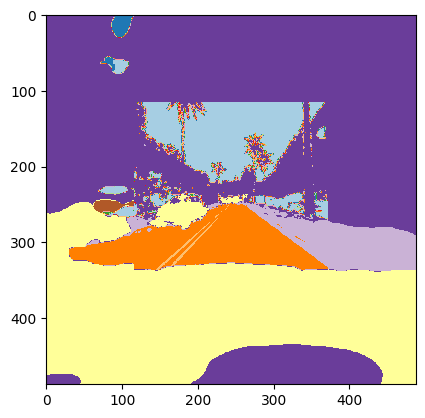

In [ ]:
pred= pred.detach().cpu()
plt.imshow(pred, cmap="Paired")

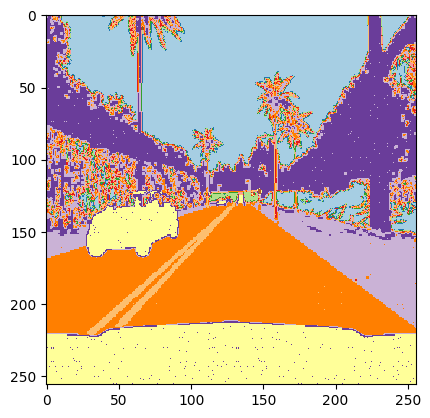

In [ ]:
plt.imshow(label, cmap="Paired")

# Generate masks

In [15]:
# acc_train =  MulticlassAccuracy().to(device)
miou_test = MeanIoU(num_classes=13, per_class=True, include_background=True).to(device)
dice = Dice(num_classes=13, average='micro').to(device)


1.  Connect to google drive
2.  cp the Model_Weights/fcn_model folder
3. Initialize the model (training code without training)
4. Load the model state dict
5. Then run the test loop


In [17]:
!cp  /content/drive/MyDrive/thesis/Model_Weights/Model_Weights/unet_model/unet_model_epoch30.pth -r /content

In [39]:
#step_4:
model_save_path = 'unet_model_epoch30.pth'
model_save_dic= torch.load(model_save_path )
unet_model.load_state_dict(model_save_dic['unet_model_state_dict'])

<All keys matched successfully>

In [41]:
unet_model.eval()
unet_loss_test=0
miout= 0
dicet=0

with torch.no_grad():

  # Go over every batch in validation loader, use for loop
  for image, label in tqdm(test_loader):
    image= image.to(device)
    label= label.to(device)

    # # get the predictions of the model
    pred= unet_model(image)

    # Compute the loss between prediction and label using loss function 
    pred = center_crop(pred, (label.shape[1], label.shape[2]))
    unet_loss_test += criterion(pred, label)

    pred = torch.argmax(softmax(pred),axis=1)
    # Compute the jaccard index between prediction and label using jaccard index function
    miout += miou_test(pred, label)

    # compute the accuracy between prediction and label 
    dicet += dice(pred, label).item()

# Append the loss to the validation loss list
print(unet_loss_test.item()/ len(test_loader))
# Append the val mIoU (average jaccard index) to val mIoU list
# print(f"the mean IOU {miout/len(test_loader)}")
print(f"the mean IOU {miou_test.compute()}")

# Append the average accuray to the val accuracy list
print(f" the dice coefficient is {dice.compute()}")






  0%|          | 0/125 [00:00<?, ?it/s]

0.1944686279296875
the mean IOU tensor([0.9681, 0.7103, 0.2808, 0.3485, 0.1450, 0.2329, 0.5181, 0.9275, 0.7773,
        0.7943, 0.9698, 0.3738, 0.1585], device='cuda:0')
 the dice coefficient is 0.9355204701423645


In [42]:
# Get a back of images and labels
batch_img, batch_label = next(iter(test_loader))

In [43]:
# Get one image and one label from the batch of images and labels
img = batch_img[0]
label = batch_label[0]

In [44]:
# Change shape from (3, 60, 80) to (1, 3, 60, 80) so our pytorch neural network does not throw a shape error
# shape error meaning: expected 4D input got 3D instead
img = img.unsqueeze(0)

In [45]:
# Generate a prediction
pred = unet_model(img.to(device))


In [46]:
# Change shape of prediction from (1, 13, 60, 80) to (13, 60, 80)
pred = pred.squeeze()

In [47]:
softmax = nn.Softmax(dim=0)

pred= torch.argmax(softmax(pred), dim=0)

In [48]:
pred= center_crop(pred, (256, 256))

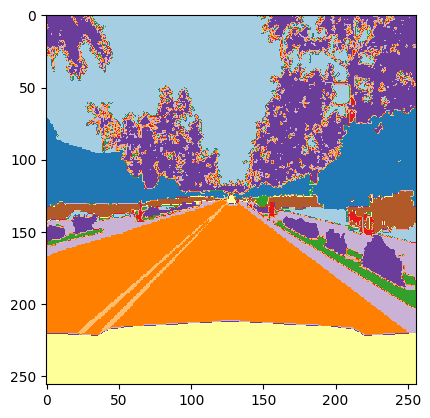

In [49]:
pred= pred.detach().cpu()
plt.imshow(pred, cmap="Paired")

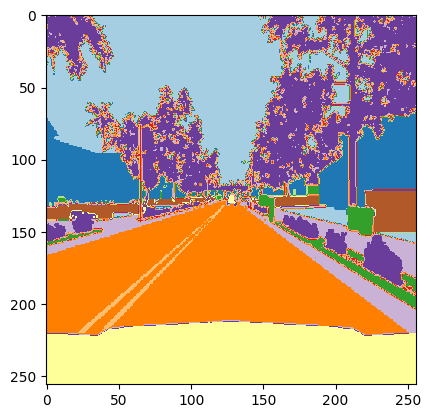

In [50]:
plt.imshow(label, cmap="Paired")